In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import cross_validate, KFold
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

/Users/psykick/Documents/learning/github/porter-regression/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/transformed/xtrain.pkl','rb') as f:
    xtrain = pickle.load(f)
with open('data/transformed/ytrain.pkl','rb') as f:
    ytrain = pickle.load(f)
with open('data/transformed/xtest.pkl','rb') as f:
    xtest = pickle.load(f)
with open('data/transformed/ytest.pkl','rb') as f:
    ytest = pickle.load(f)
with open('data/transformed/xval.pkl','rb') as f:
    xval = pickle.load(f)
with open('data/transformed/yval.pkl','rb') as f:
    yval = pickle.load(f)

# Modelling

In [3]:
# defining utils
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
model_performance = pd.DataFrame(columns=['model_name', 'train_mse', 'test_mse', 'train_mape', 'test_mape', 'train_r2', 'test_r2'])
estimators = {}

def model_scorer(clf, x, y, prefix=''):
    ypred = clf.predict(x)
    score_dict = {
        prefix+'mse': np.round(mean_squared_error(y, ypred),3),
        prefix+'mape': np.round(mean_absolute_percentage_error(y, ypred),3),
        prefix+'r2': np.round(r2_score(y, ypred),3),
    }
    return score_dict

def add_model_performance(model_name, clf, xtrain=xtrain, ytrain=ytrain, xtest=xval, ytest=yval, df=model_performance, model_dict=estimators):
    train_scores = model_scorer(clf, xtrain, ytrain, prefix='train_')
    test_scores = model_scorer(clf, xtest, ytest, prefix='test_')
    train_scores.update(test_scores)
    train_scores['model_name'] = model_name
    df.loc[df.shape[0]] = train_scores
    model_dict[model_name] = clf
    return df,model_dict

### ML Models

#### Linear regression

In [4]:
## optuna tuning
from sklearn.linear_model import LinearRegression

best_model = LinearRegression().fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='LinearRegression', clf=best_model)

display(model_performance)


,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292


#### Decision Tree Regressor

In [11]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 2, 50),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
#     }
#     model = DecisionTreeRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=100)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")

In [9]:
best_params = {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 18}
best_model = DecisionTreeRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='DecisionTreeRegressor', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240


#### XGBoost Regressor

In [12]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 501, 50),
#         'max_depth': trial.suggest_categorical('max_depth', [1,2]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'subsample': trial.suggest_discrete_uniform('subsample', 0.5, 1.0, 0.1),
#         'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.5, 1.0, 0.1),
#     }
#     model = XGBRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=100)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")


Best score: 0.632549
Best params: {'n_estimators': 460, 'max_depth': 2, 'learning_rate': 0.46385070510819, 'subsample': 1.0, 'colsample_bytree': 0.7}


In [13]:
best_params = {'n_estimators': 460, 'max_depth': 2, 'learning_rate': 0.46385070510819, 'subsample': 1.0, 'colsample_bytree': 0.7}
best_model = XGBRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='XGBRegressor', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240
2,XGBRegressor,0.616,0.659,4.124,4.508,0.384,0.336


#### Adaboost Regressor

In [15]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'n_estimators': trial.suggest_categorical('n_estimators', [1, 2]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'loss': trial.suggest_categorical('loss', ['linear', 'square', 'exponential']),
#     }
#     model = AdaBoostRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=100)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")


Best score: 0.795760
Best params: {'n_estimators': 2, 'learning_rate': 0.008622755204790793, 'loss': 'linear'}


In [16]:
best_params = {'n_estimators': 2, 'learning_rate': 0.008622755204790793, 'loss': 'linear'}
best_model = AdaBoostRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='AdaBoostRegressor', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240
2,XGBRegressor,0.616,0.659,4.124,4.508,0.384,0.336
3,AdaBoostRegressor,0.797,0.835,3.874,3.718,0.203,0.159


#### Catboost regressor

In [18]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
#         'depth': trial.suggest_categorical('depth', [1,2]),
#         'model_size_reg': trial.suggest_loguniform('model_size_reg', 1e-3, 1.0),
#         'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 1.0),
#         'verbose': trial.suggest_categorical('verbose', [0]),
#     }
#     model = CatBoostRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=50)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")


Best score: 0.629216
Best params: {'learning_rate': 0.36755109879901976, 'depth': 2, 'model_size_reg': 0.0024504381494770346, 'l2_leaf_reg': 0.002005289869443147, 'verbose': 0}


In [19]:
best_params = {'learning_rate': 0.36755109879901976, 'depth': 2, 'model_size_reg': 0.0024504381494770346, 'l2_leaf_reg': 0.002005289869443147, 'verbose': 0}
best_model = CatBoostRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='CatBoostRegressor', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240
2,XGBRegressor,0.616,0.659,4.124,4.508,0.384,0.336
3,AdaBoostRegressor,0.797,0.835,3.874,3.718,0.203,0.159
4,CatBoostRegressor,0.610,0.656,4.028,4.355,0.390,0.339


#### LightGBM Regressor

In [21]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
#         'max_depth': trial.suggest_categorical('max_depth', [1, 2]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e0),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 3001, 10),
#         'verbosity': trial.suggest_categorical('verbosity', [-1]),
#     }
#     model = LGBMRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=50)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")


Best score: 0.628543
Best params: {'boosting_type': 'gbdt', 'max_depth': 2, 'learning_rate': 0.18538250531373315, 'n_estimators': 1840, 'verbosity': -1}


In [22]:
best_params = {'boosting_type': 'gbdt', 'max_depth': 2, 'learning_rate': 0.18538250531373315, 'n_estimators': 1840, 'verbosity': -1}
best_model = LGBMRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='LGBMRegressor', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240
2,XGBRegressor,0.616,0.659,4.124,4.508,0.384,0.336
3,AdaBoostRegressor,0.797,0.835,3.874,3.718,0.203,0.159
4,CatBoostRegressor,0.610,0.656,4.028,4.355,0.390,0.339
5,LGBMRegressor,0.607,0.653,4.085,4.454,0.393,0.342


#### LightGBM Random Forest Regressor

In [24]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'boosting_type': trial.suggest_categorical('boosting_type', ['rf']),
#         'max_depth': trial.suggest_categorical('max_depth', [10]),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e0),
#         'n_estimators': trial.suggest_int('n_estimators', 10, 3001, 10),
#         'verbosity': trial.suggest_categorical('verbosity', [-1]),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0)
#     }
#     model = LGBMRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=50)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")


Best score: 0.734050
Best params: {'boosting_type': 'rf', 'max_depth': 10, 'learning_rate': 0.002738801507209298, 'n_estimators': 640, 'verbosity': -1, 'bagging_freq': 9, 'feature_fraction': 0.7503759362455543}


In [25]:
best_params = {'boosting_type': 'rf', 'max_depth': 10, 'learning_rate': 0.002738801507209298, 'n_estimators': 640, 'verbosity': -1, 'bagging_freq': 9, 'feature_fraction': 0.7503759362455543}
best_model = LGBMRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='LGBMRegressorRF', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240
2,XGBRegressor,0.616,0.659,4.124,4.508,0.384,0.336
3,AdaBoostRegressor,0.797,0.835,3.874,3.718,0.203,0.159
4,CatBoostRegressor,0.610,0.656,4.028,4.355,0.390,0.339
5,LGBMRegressor,0.607,0.653,4.085,4.454,0.393,0.342
6,LGBMRegressorRF,0.730,0.759,3.495,3.492,0.270,0.235


#### Random Forest (sklearn)

In [28]:
# def objective(trial, xtrain, ytrain, kf):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 501, 50),
#         'max_depth': trial.suggest_int('max_depth', 10, 1000),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
#         'n_jobs': -1,
#         'ccp_alpha': trial.suggest_loguniform('ccp_alpha', 1e-3, 1.0),
#     }
#     model = RandomForestRegressor(**params)
#     scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
#     loss = -scores['test_score'].mean()
#     return loss

# kf = KFold(n_splits=3, shuffle=True, random_state=42)
# obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
# study = optuna.create_study(direction='minimize')
# study.optimize(obj_func, n_trials=50)

# print(f"Best score: {study.best_value:5f}")
# print(f"Best params: {study.best_params}")


Best score: 0.742061
Best params: {'n_estimators': 160, 'max_depth': 74, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'log2', 'ccp_alpha': 0.001024857598240197}


In [29]:
best_params = {'n_estimators': 160, 'max_depth': 74, 'min_samples_split': 5, 'min_samples_leaf': 18, 'max_features': 'log2', 'ccp_alpha': 0.001024857598240197}
best_model = RandomForestRegressor(**best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='RandomForestRegressor', clf=best_model)

display(model_performance)

,model_name,train_mse,test_mse,train_mape,test_mape,train_r2,test_r2
0,LinearRegression,0.684,0.703,4.116,4.164,0.316,0.292
1,DecisionTreeRegressor,0.689,0.754,4.150,4.079,0.311,0.240
2,XGBRegressor,0.616,0.659,4.124,4.508,0.384,0.336
3,AdaBoostRegressor,0.797,0.835,3.874,3.718,0.203,0.159
4,CatBoostRegressor,0.610,0.656,4.028,4.355,0.390,0.339
5,LGBMRegressor,0.607,0.653,4.085,4.454,0.393,0.342
6,LGBMRegressorRF,0.730,0.759,3.495,3.492,0.270,0.235
7,RandomForestRegressor,0.740,0.770,3.480,3.345,0.260,0.224


### Neural networks

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, sigmoid, linear, tanh, softmax
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.losses import mse, mean_absolute_error, mape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [ ]:
input_shape = (xtrain.shape[1],)
batch_size = 32

In [ ]:
# util functions

def plot_loss(history):

    # getting metrics at minimum validation mse
    idx = np.argmin(history.history['val_loss'])

    train_loss = history.history['loss'][idx]
    val_loss = history.history['val_loss'][idx]
    train_mae = history.history['mean_absolute_error'][idx]
    val_mae = history.history['val_mean_absolute_error'][idx]
    train_mape = history.history['mean_absolute_percentage_error'][idx]
    val_mape = history.history['val_mean_absolute_percentage_error'][idx]

    print(f"Train loss = {train_loss}")
    print(f"Val loss = {val_loss}")
    print(f"Train mae = {train_mae}")
    print(f"Val mae = {val_mae}")
    print(f"Train mape = {train_mape}")
    print(f"Val mape = {val_mape}")

    # plotting the loss vs epoch curve
    epochs = len(history.history['loss'])
    fig, ax = plt.subplots(1,3,figsize=(20,4))

    # plotting mse
    sns.lineplot(x=range(epochs), y=history.history['loss'], ax=ax[0], label='train mse')
    sns.lineplot(x=range(epochs), y=history.history['val_loss'], ax=ax[0], label='val mse')

    # plotting mae
    sns.lineplot(x=range(epochs), y=history.history['mean_absolute_error'], ax=ax[1], label='train mae')
    sns.lineplot(x=range(epochs), y=history.history['val_mean_absolute_error'], ax=ax[1], label='val mae')

    # plotting mape
    sns.lineplot(x=range(epochs), y=history.history['mean_absolute_percentage_error'], ax=ax[2], label='train mape')
    sns.lineplot(x=range(epochs), y=history.history['val_mean_absolute_percentage_error'], ax=ax[2], label='val mape')

    # renaming axes
    ax[0].set_xlabel('epoch')
    ax[1].set_xlabel('epoch')
    ax[2].set_xlabel('epoch')
    ax[0].set_ylabel('mse')
    ax[1].set_ylabel('mae')
    ax[2].set_ylabel('mape')
    ax[0].set_title('MSE')
    ax[1].set_title('MAE')
    ax[2].set_title('MAPE')

    plt.suptitle('Loss Plots')
    plt.tight_layout()
    plt.show()

### Simple ANN

In [ ]:
def get_model():

    input = Input(shape=input_shape)

    x = Dense(264, kernel_initializer='glorot_uniform', bias_initializer='zeros')(input)
    x = relu(x)

    x = Dense(128, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(64, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(32, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(16, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(1, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    output = linear(x)

    model = Model(inputs=input, outputs=output)

    return model

model = get_model()

model.compile(
    optimizer='adam',
    loss=mse,
    metrics=[mean_absolute_error,mape]
)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense (Dense)               (None, 264)               3960      
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 264)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               33920     
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 tf.nn.relu_2 (TFOpLambda)   (None, 64)                0   

In [ ]:
history = model.fit(xtrain,ytrain,batch_size=batch_size,epochs=20, validation_data=(xval,yval))

Epoch 1/20


3949/3949 [==============================] - 8s 2ms/step - loss: 0.6784 - mean_absolute_error: 0.6365 - mean_absolute_percentage_error: 421.1910 - val_loss: 0.6851 - val_mean_absolute_error: 0.6420 - val_mean_absolute_percentage_error: 375.5794
Epoch 2/20
3949/3949 [==============================] - 7s 2ms/step - loss: 0.6586 - mean_absolute_error: 0.6267 - mean_absolute_percentage_error: 415.6272 - val_loss: 0.6816 - val_mean_absolute_error: 0.6390 - val_mean_absolute_percentage_error: 458.9173
Epoch 3/20
3949/3949 [==============================] - 7s 2ms/step - loss: 0.6530 - mean_absolute_error: 0.6239 - mean_absolute_percentage_error: 418.8744 - val_loss: 0.6810 - val_mean_absolute_error: 0.6380 - val_mean_absolute_percentage_error: 419.8454
Epoch 4/20
3949/3949 [==============================] - 7s 2ms/step - loss: 0.6494 - mean_absolute_error: 0.6221 - mean_absolute_percentage_error: 410.8258 - val_loss: 0.6760 - val_mean_absolute_error: 0.6371 - val_mean_absolute_p

Train loss = 0.6369912028312683
Val loss = 0.6692585945129395
Train mae = 0.6157525777816772
Val mae = 0.6338945031166077
Train mape = 417.8258056640625
Val mape = 452.8489074707031


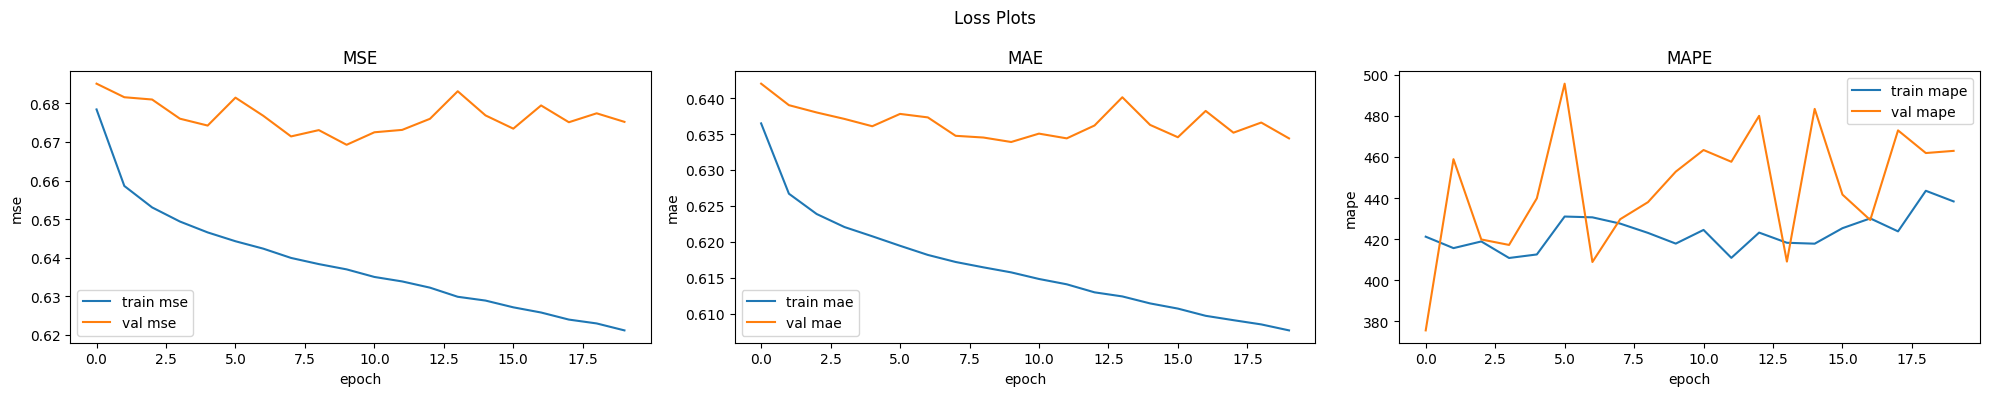

In [ ]:
plot_loss(history)

### Making the model more complex

In [ ]:
def get_model():

    input = Input(shape=input_shape)

    x = Dense(512, kernel_initializer='glorot_uniform', bias_initializer='zeros')(input)
    x = relu(x)

    x = Dense(264, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(128, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(64, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(32, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(16, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(8, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(1, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    output = linear(x)

    model = Model(inputs=input, outputs=output)

    return model

model = get_model()

model.compile(
    optimizer='adam',
    loss=mse,
    metrics=[mean_absolute_error,mape]
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_6 (Dense)             (None, 512)               7680      
                                                                 
 tf.nn.relu_5 (TFOpLambda)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 264)               135432    
                                                                 
 tf.nn.relu_6 (TFOpLambda)   (None, 264)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               33920     
                                                                 
 tf.nn.relu_7 (TFOpLambda)   (None, 128)               0   

In [ ]:
history = model.fit(xtrain,ytrain,batch_size=batch_size,epochs=20, validation_data=(xval,yval))

Epoch 1/20
3949/3949 [==============================] - 13s 3ms/step - loss: 0.6968 - mean_absolute_error: 0.6455 - mean_absolute_percentage_error: 396.8423 - val_loss: 0.6960 - val_mean_absolute_error: 0.6465 - val_mean_absolute_percentage_error: 426.0460
Epoch 2/20
3949/3949 [==============================] - 11s 3ms/step - loss: 0.6603 - mean_absolute_error: 0.6279 - mean_absolute_percentage_error: 433.6191 - val_loss: 0.6872 - val_mean_absolute_error: 0.6437 - val_mean_absolute_percentage_error: 467.5676
Epoch 3/20
3949/3949 [==============================] - 11s 3ms/step - loss: 0.6554 - mean_absolute_error: 0.6252 - mean_absolute_percentage_error: 425.0814 - val_loss: 0.6830 - val_mean_absolute_error: 0.6408 - val_mean_absolute_percentage_error: 398.8141
Epoch 4/20
3949/3949 [==============================] - 11s 3ms/step - loss: 0.6507 - mean_absolute_error: 0.6227 - mean_absolute_percentage_error: 421.9477 - val_loss: 0.6782 - val_mean_absolute_error: 0.6383 - val_mean_absolute

Train loss = 0.6335616111755371
Val loss = 0.6694946885108948
Train mae = 0.613910436630249
Val mae = 0.6337601542472839
Train mape = 417.1047058105469
Val mape = 429.28173828125


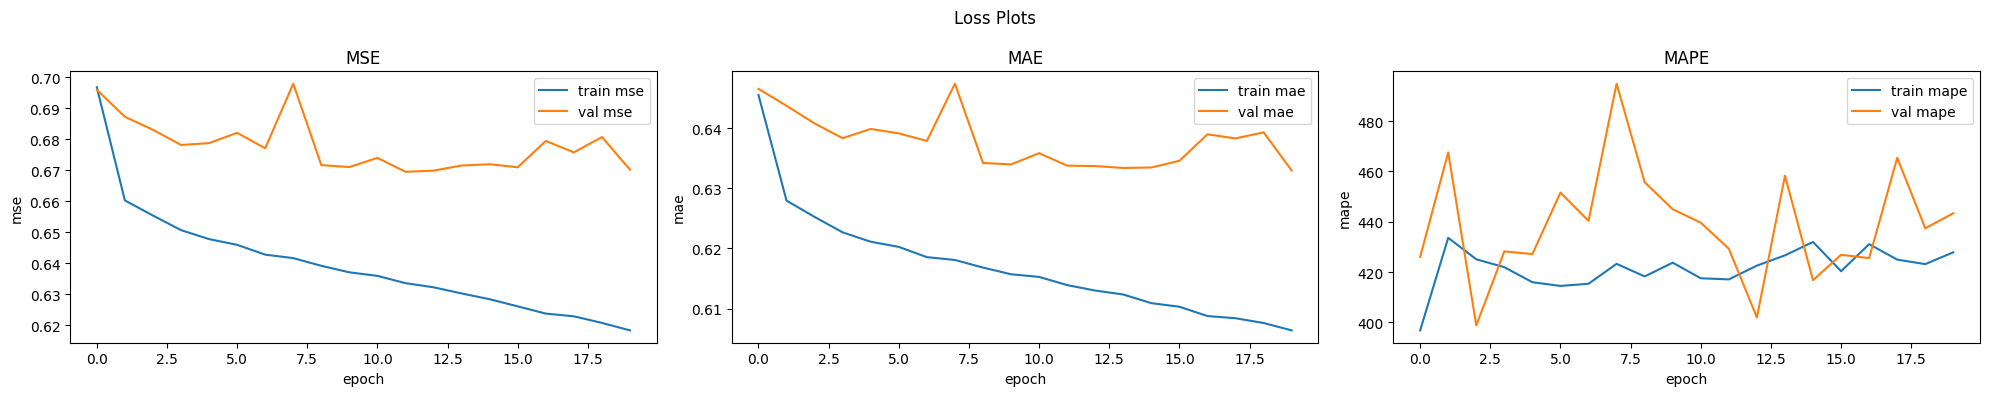

In [ ]:
plot_loss(history)

### Adding dropout and batch normalization

In [ ]:
def get_model():

    input = Input(shape=input_shape)

    x = Dense(512, kernel_initializer='glorot_uniform', bias_initializer='zeros')(input)
    x = relu(x)

    x = Dense(264, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(64, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(16, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(8, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    x = relu(x)

    x = Dense(1, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)
    output = linear(x)

    model = Model(inputs=input, outputs=output)

    return model

model = get_model()

model.compile(
    optimizer='adam',
    loss=mse,
    metrics=[mean_absolute_error,mape]
)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense (Dense)               (None, 512)               7680      
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 264)               135432    
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 264)               0         
                                                                 
 batch_normalization (Batch  (None, 264)               1056      
 Normalization)                                                  
                                                           

In [ ]:
history = model.fit(xtrain,ytrain,batch_size=batch_size,epochs=30, validation_data=(xval,yval))

Epoch 1/30


3949/3949 [==============================] - 19s 4ms/step - loss: 0.7694 - mean_absolute_error: 0.6775 - mean_absolute_percentage_error: 425.1681 - val_loss: 0.6955 - val_mean_absolute_error: 0.6470 - val_mean_absolute_percentage_error: 410.5624
Epoch 2/30
3949/3949 [==============================] - 15s 4ms/step - loss: 0.6907 - mean_absolute_error: 0.6435 - mean_absolute_percentage_error: 429.9109 - val_loss: 0.6889 - val_mean_absolute_error: 0.6450 - val_mean_absolute_percentage_error: 427.2956
Epoch 3/30
3949/3949 [==============================] - 15s 4ms/step - loss: 0.6831 - mean_absolute_error: 0.6390 - mean_absolute_percentage_error: 420.0644 - val_loss: 0.6903 - val_mean_absolute_error: 0.6449 - val_mean_absolute_percentage_error: 424.3862
Epoch 4/30
3949/3949 [==============================] - 15s 4ms/step - loss: 0.6776 - mean_absolute_error: 0.6368 - mean_absolute_percentage_error: 416.8718 - val_loss: 0.6797 - val_mean_absolute_error: 0.6385 - val_mean_absolu

Train loss = 0.6511195302009583
Val loss = 0.6726742386817932
Train mae = 0.6232760548591614
Val mae = 0.6349693536758423
Train mape = 419.40399169921875
Val mape = 412.01739501953125


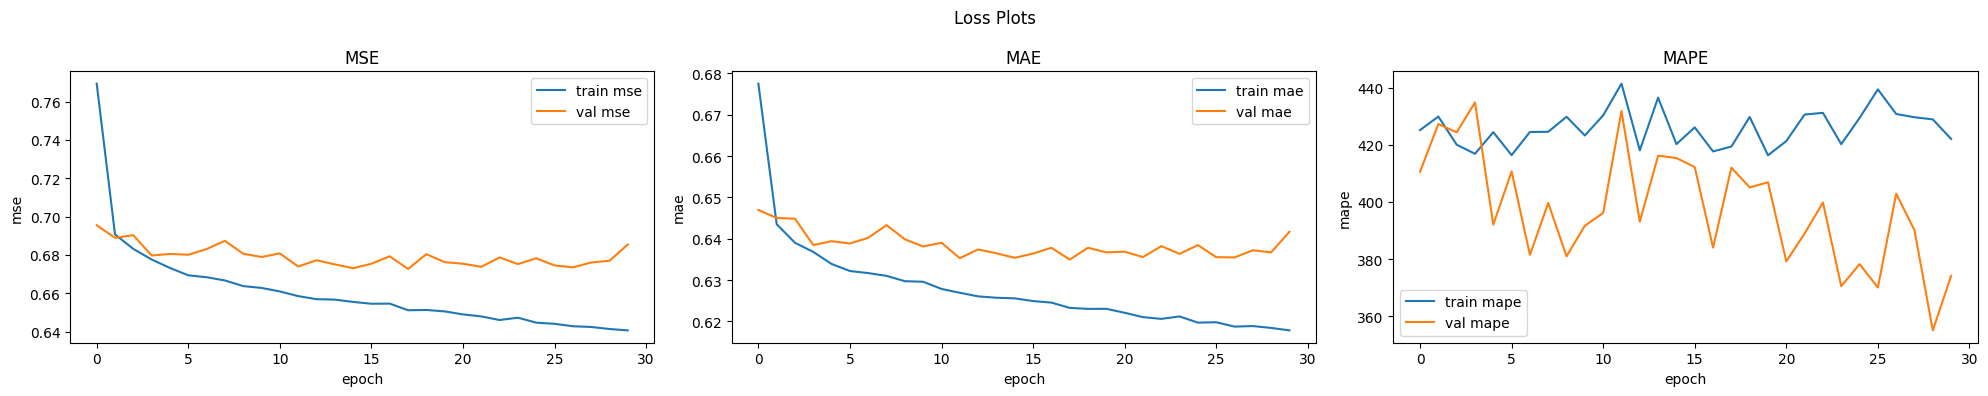

In [ ]:
plot_loss(history)

### Adding regularization and training for more epochs

In [ ]:
def get_model():

    input = Input(shape=input_shape)

    x = Dense(512, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(input)
    x = relu(x)

    x = Dense(264, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = relu(x)

    x = Dense(64, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(32, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = relu(x)

    x = Dense(16, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = relu(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(8, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = relu(x)

    x = Dense(1, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer='l2', bias_regularizer='l2')(x)
    output = linear(x)

    model = Model(inputs=input, outputs=output)

    return model

model = get_model()

model.compile(
    optimizer='adam',
    loss=mse,
    metrics=[mean_absolute_error,mape]
)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_22 (Dense)            (None, 512)               7680      
                                                                 
 tf.nn.relu_19 (TFOpLambda)  (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 264)               135432    
                                                                 
 tf.nn.relu_20 (TFOpLambda)  (None, 264)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 264)               1056      
 chNormalization)                                                
                                                           

In [ ]:
history = model.fit(xtrain,ytrain,batch_size=batch_size,epochs=50, validation_data=(xval,yval))

Epoch 1/50
3949/3949 [==============================] - 20s 4ms/step - loss: 1.7964 - mean_absolute_error: 0.6678 - mean_absolute_percentage_error: 400.2664 - val_loss: 0.7531 - val_mean_absolute_error: 0.6559 - val_mean_absolute_percentage_error: 351.5140
Epoch 2/50
3949/3949 [==============================] - 18s 4ms/step - loss: 0.7486 - mean_absolute_error: 0.6501 - mean_absolute_percentage_error: 404.6769 - val_loss: 0.7565 - val_mean_absolute_error: 0.6537 - val_mean_absolute_percentage_error: 524.6544
Epoch 3/50
3949/3949 [==============================] - 16s 4ms/step - loss: 0.7521 - mean_absolute_error: 0.6488 - mean_absolute_percentage_error: 440.4637 - val_loss: 0.7577 - val_mean_absolute_error: 0.6550 - val_mean_absolute_percentage_error: 464.3718
Epoch 4/50
3949/3949 [==============================] - 18s 4ms/step - loss: 0.7498 - mean_absolute_error: 0.6483 - mean_absolute_percentage_error: 399.8104 - val_loss: 0.7602 - val_mean_absolute_error: 0.6528 - val_mean_absolute

Train loss = 0.7377931475639343
Val loss = 0.7244970202445984
Train mae = 0.6481765508651733
Val mae = 0.645415723323822
Train mape = 442.18450927734375
Val mape = 416.9627380371094


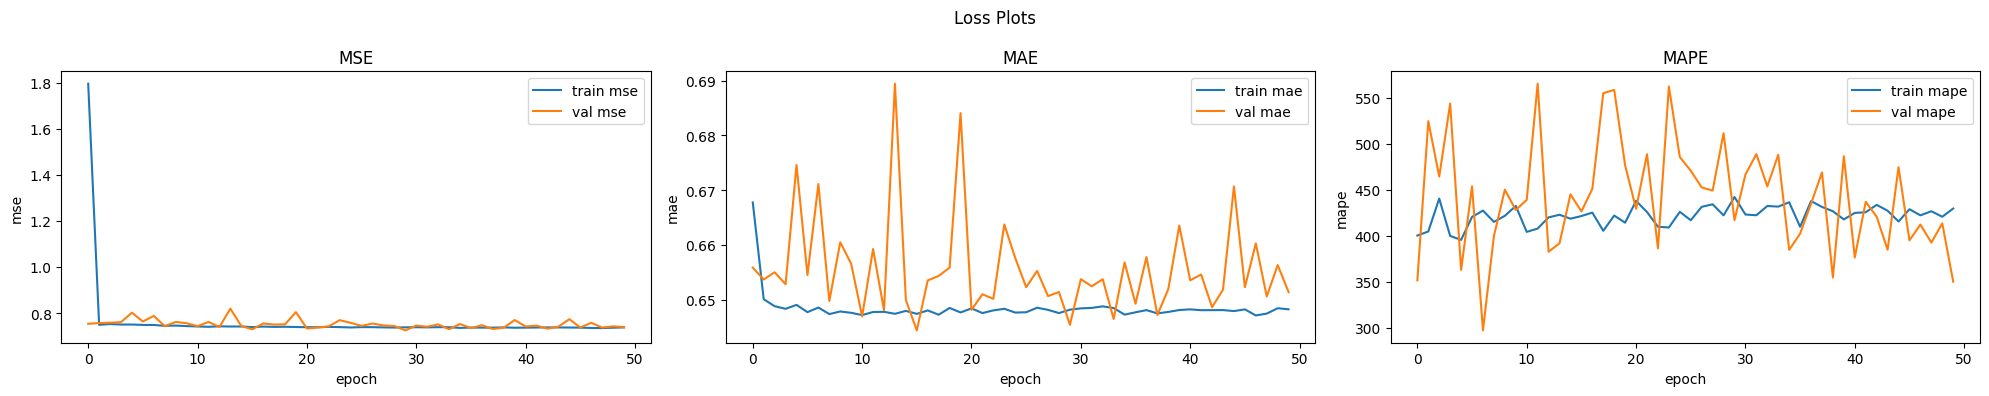

In [ ]:
plot_loss(history)

## Testing with the best model

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as skl_mape, mean_squared_error as skl_mse, mean_absolute_error as skl_mae

y_pred = model.predict(xtest)

mse = skl_mse(ytest,y_pred)
mae = skl_mae(ytest,y_pred)
mape = skl_mape(ytest,y_pred)

print(f"Test mse = {mse:.4f}")
print(f"Test mae = {mae:.4f}")
print(f"Test mape = {mape:.4f}")

1234/1234 [==============================] - 2s 1ms/step
Test mse = 0.6837
Test mae = 0.6409
Test mape = 3.5324


# Conclusion

- The delivery time was not explicitely present in the dataset, we derived it using existing features.
- The log of delivery time follows a bell-shaped distribution
- We treated categorical null values by filling them with unknown, and numerical null values by mean imputation using train data
- There was no strong relation observed between the features and the target in the visual analysis
- We removed the outliers using the IQR technique
- We tried different architecture of neural networks, dealt with overfitting and tested the best model on the test data
- The test scores for the best model was mse = 0.6837, mae = 0.6409 and mape = 3.5324